In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
import h5py

In [3]:
!cp bunchmonitor.h5 bm.h5
!cp particlemonitor.h5part pm.h5part

In [4]:
with h5py.File('./bm.h5', 'r') as fb:
    rec_mean_x = np.array(fb['Bunch']['mean_x'])
    rec_mean_y = np.array(fb['Bunch']['mean_y'])
    rec_epsn_x = np.array(fb['Bunch']['epsn_x'])
    rec_epsn_y = np.array(fb['Bunch']['epsn_y'])

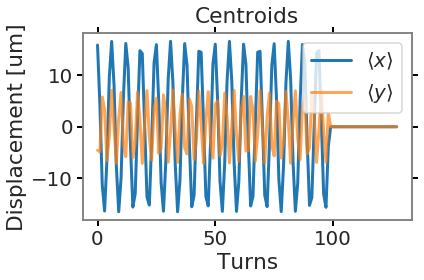

In [5]:
plt.plot(rec_mean_x * 1e6, label=r'$\langle x \rangle$')
plt.plot(rec_mean_y * 1e6, label=r'$\langle y \rangle$', alpha=0.7)
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Displacement [um]')
plt.title('Centroids', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('SIS100_with_PIC_SC_centroids.png', dpi=150, bbox_inches='tight')

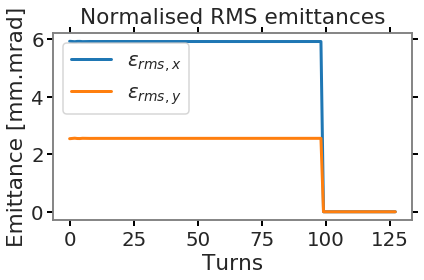

In [6]:
plt.plot(rec_epsn_x * 1e6, label=r'$\epsilon_{rms,x}$')
plt.plot(rec_epsn_y * 1e6, label=r'$\epsilon_{rms,y}$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Normalised RMS emittances', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('SIS100_with_PIC_SC_epsnxy.png', dpi=150, bbox_inches='tight')

In [7]:
with h5py.File('pm.h5part', 'r') as fp:
    n_steps = len([st for st in fp.keys() if 'Step' in st])
    n_stored_particles = len(fp['Step#0']['x'])
    
    rec_inc_x = np.empty((n_steps, n_stored_particles), dtype=np.float32)
    rec_inc_xp = np.empty_like(rec_inc_x)
    rec_inc_y = np.empty_like(rec_inc_x)
    rec_inc_yp = np.empty_like(rec_inc_x)
    rec_inc_z = np.empty_like(rec_inc_x)
    rec_inc_dp = np.empty_like(rec_inc_x)
    
    for i in range(n_steps):
        rec_inc_x[i, :] = fp['Step#{}'.format(i)]['x']
        rec_inc_xp[i, :] = fp['Step#{}'.format(i)]['xp']
        rec_inc_y[i, :] = fp['Step#{}'.format(i)]['y']
        rec_inc_yp[i, :] = fp['Step#{}'.format(i)]['yp']
        rec_inc_z[i, :] = fp['Step#{}'.format(i)]['z']
        rec_inc_dp[i, :] = fp['Step#{}'.format(i)]['dp']

In [8]:
id_max = 0

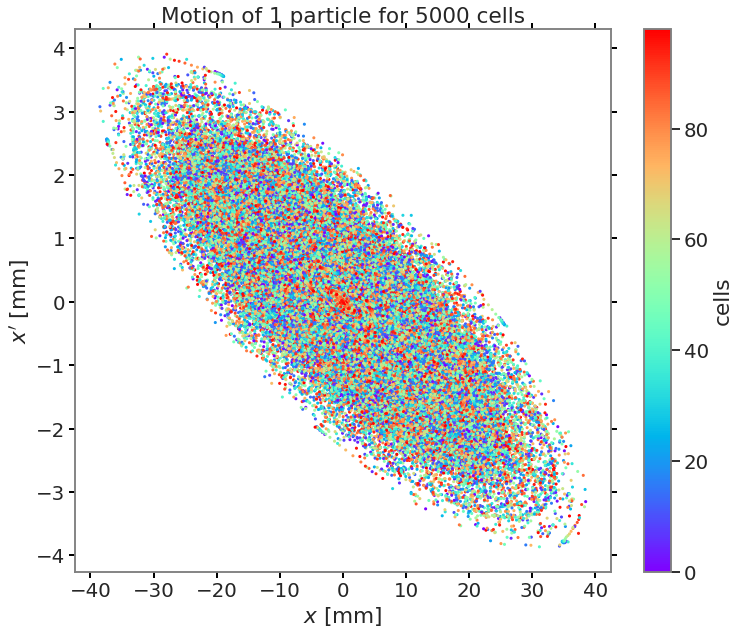

In [9]:
plt.figure(figsize=(12, 10))
for id_max in range(1000):
    plt.scatter(rec_inc_x[:, id_max] * 1e3, rec_inc_xp[:, id_max] * 1e3, marker='.', 
                s=10, c=np.arange(len(rec_inc_x[:, id_max])), cmap=plt.get_cmap('rainbow'))
cbar = plt.colorbar()
cbar.set_label('cells')
# plt.hist2d(pyht_beam.x[peak_ids] * 1e3, pyht_beam.xp[peak_ids] * 1e3, bins=100);
plt.xlabel('$x$ [mm]')
plt.ylabel(r"$x'$ [mm]")
plt.title('Motion of 1 particle for 5000 cells')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('SIS100_with_PIC_SC_particlemotion.png', dpi=150, bbox_inches='tight')

# Foot print

In [10]:
import PyNAFF as pnf
from tune_diagram import ResonanceLines

In [11]:
turns = n_steps-1

In [12]:
def get_tune_100(signal_100_turns):
    return pnf.naff(signal_100_turns, turns, 1, 0 , False, window=1)[0,1]

In [13]:
qx_i = np.apply_along_axis(get_tune_100, 1, rec_inc_x.T)
qy_i = np.apply_along_axis(get_tune_100, 1, rec_inc_y.T)

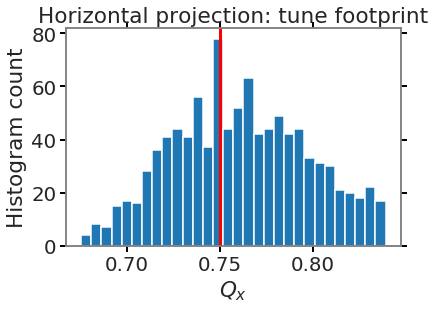

In [14]:
n, bins, _ = plt.hist(1 - qx_i, bins=30, label='128 first turns')
plt.axvline(0.75, color='red')
plt.xlabel("$Q_x$")
plt.ylabel('Histogram count')
plt.title('Horizontal projection: tune footprint')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('horizontalspectrum.png', dpi=150, bbox_inches='tight')

In [15]:
print ('max. dQ_x from tune footprint: {:.3f}'.format(bins[-1] - bins[0]))

max. dQ_x from tune footprint: 0.164


In [16]:
Qx = 18.84
Qy = 18.73

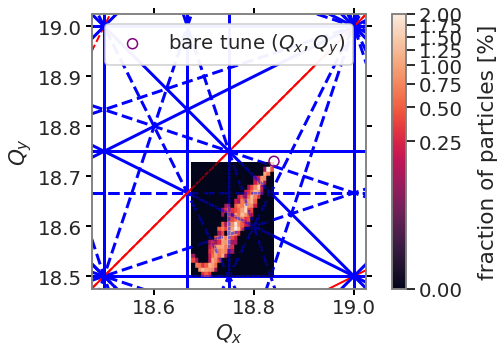

In [17]:
fig = plt.figure(figsize=(8,5)) 

extent_x = (np.floor(Qx) + 0.475, np.ceil(Qx) + 0.025)
extent_y = (np.floor(Qy) + 0.475, np.ceil(Qy) + 0.025)

resonances = ResonanceLines(extent_x, 
                            extent_y,
                            range(1, 4+1), 6) #1
resonances.plot_resonance(fig)
plt.gca().set_aspect('equal')

inc_tunes_x = np.floor(Qx) + 1 - np.abs(qx_i)
inc_tunes_y = np.floor(Qy) + 1 - np.abs(qy_i)

plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25,
           zorder=12, alpha=0.5, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
cbar = plt.colorbar()
cbar.set_label('fraction of particles [%]', labelpad=15)

plt.xlim(extent_x)
plt.ylim(extent_y)

plt.scatter(Qx, Qy, color='purple', marker='o', facecolor='None', 
            linestyle='None', s=100, zorder=13, label=r"bare tune $(Q_x,Q_y)$")
plt.legend(loc=9, framealpha=0.95)

plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)

plt.tight_layout()
plt.savefig('tunespread.png', dpi=150, bbox_inches='tight')

In [18]:
np.std(rec_inc_dp)

9.555038e-16

In [19]:
np.std(rec_inc_z[0,:])

14.109384

In [20]:
np.std(rec_inc_x[0,:]), np.std(rec_inc_x[-1,:])

(0.011698994, 0.01157512)

In [21]:
np.std(rec_inc_y[0,:]), np.std(rec_inc_y[-1,:])

(0.0044218153, 0.004439546)

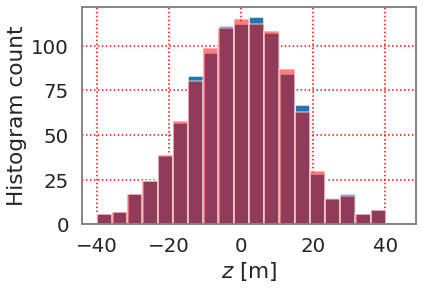

In [22]:
plt.hist(rec_inc_z[0,:], bins=20);
plt.hist(rec_inc_z[-1,:], bins=20, color='red', alpha=0.5);
plt.ylabel('Histogram count')
plt.xlabel('$z$ [m]');

chromatic tune spread:

In [23]:
np.sqrt(1 - (15.75515332**-2 - -0.67)) * 40 * 0.5e-3

0.011418780925882893